## Modeling Habitat Suitability of Sorghastrum nutans

Sorghastrum nutans (Indiangrass) is native to North America, however in the past 50 years its range has progressively moved northward (citation). To understand future projections of habitat suitability of this grass, I analyze multiple data layers related to soil, topography and climate.

In this notebook, I analyze the habitat suitability of two Colorado National Grasslands (Pawnee and Comanche) 50 and 75 years into the future under 8.5 RCP climate conditions. MORE DETAILS HERE

NEED TO ADD PLOT TITLES EVERYWHERE, RESEARCH + CITATIONS, AND DATA DESCRIPTIONS
ALSO RENEW THE DOI, AND README AND DESCRIBE RESULTS + ALL FIGURES
MAYBE ADD SOME PICS 

In [1]:
# Import packages
import io
import math 
import os
from glob import glob
import earthpy as et
import earthaccess
import pathlib
#import earthpy.appeears as etapp
import geopandas as gpd
import hvplot.xarray  
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import requests
import xarray as xr
import zipfile
import xrspatial
from xrspatial import aspect
from xrspatial import slope
import warnings
warnings.filterwarnings('ignore')

c:\Users\anpo9052\AppData\Local\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Creating data directories

In [2]:
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'final-project')
boundaries_dir = os.path.join(data_dir, 'boundaries')
polaris_dir = os.path.join(data_dir, 'polaris')
elevation_dir = os.path.join(data_dir, 'elevation')
precipitation_dir = os.path.join(data_dir, 'precipitation')

for dir in [data_dir, boundaries_dir, polaris_dir, precipitation_dir, elevation_dir]:
    """
    Create directories if they don't exist
    """
    if not os.path.exists(dir):
        os.makedirs(dir)

# Define utm zone
utm = 32613

## Dowloading Data for Pawnee and Comanche National Grasslands

### Data Citation:
United States Forest Service (USFS). (2023). U.S. National Grassland Shapefiles [Data set]. USFS Enterprise Data Warehouse. Accessed 2024-11-20 from https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip

In [3]:
# Define the download URL for the study area
usfs_grassland_url = (
    'https://data.fs.usda.gov/geodata/edw'
    '/edw_resources/shp/S_USA.NationalGrassland.zip'
)
# Check the URL is correct
try:
    grass_shapefile = os.path.join(
        boundaries_dir, 'grasslands.shp')
    if not os.listdir(boundaries_dir):
        gdf = gpd.read_file(usfs_grassland_url)
        gdf.to_file(grass_shapefile)
    else:
        gdf = gpd.read_file(grass_shapefile)
except URLError as e:
    print(f"Failed to open URL: {e.reason}")

In [4]:
# Select the two study areas and look at it
selectedgrass_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[
                     'Comanche National Grassland', 
                     'Pawnee National Grassland',
                  ]])
selectedgrass_gdf

,NATIONALGR,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
GRASSLANDN,,,,,
Comanche National Grassland,295522010328,444413.904,0.183064,26.658022,"MULTIPOLYGON (((-104.02263 37.69224, -104.0225..."
Pawnee National Grassland,295523010328,208424.885,0.089972,15.341594,"MULTIPOLYGON (((-104.58106 40.82664, -104.5810..."


<Axes: >

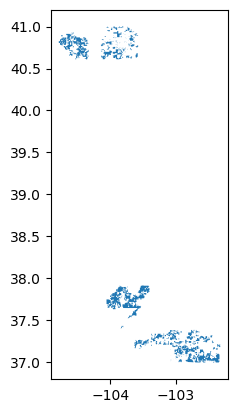

In [5]:
# Make a quick plot to check data
selectedgrass_gdf.plot()

<Axes: >

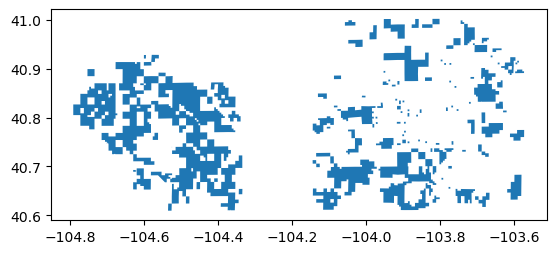

In [6]:
# Map of Pawnee
Pawnee_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[ 
                     'Pawnee National Grassland',
                  ]])
Pawnee_gdf.plot()

<Axes: >

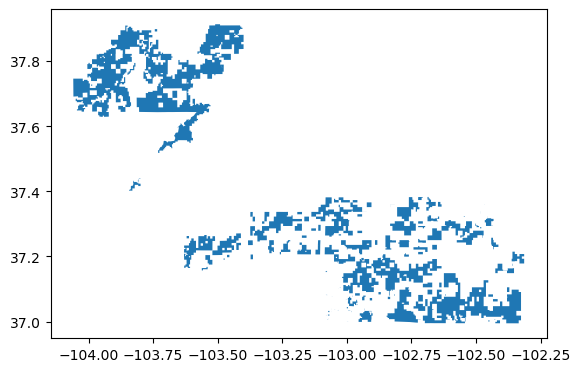

In [7]:
# Map of Comanche
Comanche_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[
                     'Comanche National Grassland', 
                  ]])
Comanche_gdf.plot()

## Downloading soil pH data

### Data Citation:
Duke University. (2019). POLARIS Soil Properties v1.0: pH Mean 60-100 cm Depth [Data set]. Duke University Hydrology Laboratory. Accessed 2024-11-20 from http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/

SHOULD ALSO CITE THIS FUNCTION: 

In [8]:
def get_polaris_data(data_directory, input_gdf, index_col_name):
    """
    This function downloads Polaris soil data for the extent of each
    row in a geodataframe and creates a merged data array for each.
    Downloaded data is saved in individual folders for each row. Merged
    data arrays for each row are saved in "Merged_files" subfolder.

    Paramters
    ----------
    data_directory : path
        The path to the data directory. A sub-directory will be created
        within this directory for the soil data downloads.

    input_gdf: geopandas.GeoDataFrame
        A geodataframe that contains the areas of interest. Polaris soil
        data will be downloaded according to the bounds of each row in
        the dataframe.

    index_col_name: string
        A string containing the name of the geoDataFrame column that
        should be used as the index. This index will be used to name
        output files.

    Returns
    ----------
    output_lst: list of data arrays
        Returns a list of data arrays representing the merged Polaris
        tif data for each row in the input geodataframe
    """

    # Set index to specified index column
    input_gdf = input_gdf.reset_index().set_index(index_col_name)

    # Create dataframe of bounds of each gdf row
    bound_pd = pd.concat([input_gdf.bounds], axis=1)

    file_list = []
    # Loop through each row in the boundary dataframe
    for ind in bound_pd.index:
        print("\n", ind, ":")
        # Define and round min and max longitude and latitudes
        min_lon = math.floor(bound_pd["minx"][ind])
        max_lon = math.ceil(bound_pd["maxx"][ind])
        min_lat = math.floor(bound_pd["miny"][ind])
        max_lat = math.ceil(bound_pd["maxy"][ind])
        # Define range
        lat_range = range(min_lat, max_lat)
        lon_range = range(min_lon, max_lon)

        # Create template for polaris url path
        polaris_template_url = (
            "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
            "{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif"
        )
        # Create template for file names
        polaris_template_name = "mean_ph_lat{0}{1}_lon{2}{3}.tif"

        # Create sub-directory for soil data
        soil_dir = os.path.join(data_directory, "soil_data")
        if not os.path.exists(soil_dir):
            os.makedirs(soil_dir)

        # Create sub-folders for each row's data
        soil_row_dir = os.path.join(soil_dir, str(ind).replace(" ", "_"))
        if not os.path.exists(soil_row_dir):
            os.makedirs(soil_row_dir)

        # Create sub-folder for merged data arrays
        soil_merged_dir = os.path.join(soil_dir, "Merged_tifs")
        if not os.path.exists(soil_merged_dir):
            os.makedirs(soil_merged_dir)

        # For each latitude and longitude in the extent, download file
        for lat in lat_range:
            for lon in lon_range:
                # Define url for each data file in extent
                url = polaris_template_url.format(
                    "ph",
                    "mean",
                    "60_100",
                    str(lat),
                    str(lat + 1),
                    str(lon),
                    str(lon + 1),
                )
                # Define file name for each data file in extent
                file_name = polaris_template_name.format(
                    str(lat), str(lat + 1), str(lon), str(lon + 1)
                )
                # Check if tif file is in directory. Download if not.
                file_name_path = os.path.join(soil_row_dir, file_name)
                if not os.path.exists(file_name_path):
                    print(file_name, "does not exist. Downloading file")
                    r = requests.get(url, allow_redirects=True)
                    open(file_name_path, "wb").write(r.content)
                else:
                    print(file_name, "is already downloaded")

        # Define the name for the merged file
        merge_template_name = "{0}_merged_da.tif"
        merge_da_name = (
            merge_template_name.format(str(ind)
                                       .replace(" ", "_"), ".tif"))
        # Merge arrays if the merged file does not exist
        if not os.path.exists(os.path.join(soil_merged_dir, merge_da_name)):
            print("Soil data is being merged.")
            tif_paths = glob(os.path.join(soil_row_dir, "*.tif"))
            das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
            merged_da = rxrmerge.merge_arrays(das)
            merged_da.rio.to_raster(
                os.path.join(soil_merged_dir, merge_da_name)
                )
            print("Merged soil file created.")
        # Otherwise, load existing merged file
        else:
            print("A merged soil data array already exists.")
            merged_da = rxr.open_rasterio(
                os.path.join(soil_merged_dir, merge_da_name), masked=True
            )

        # Add file to list of tif files to return
        file_list.append(os.path.join(soil_merged_dir, merge_da_name))
    # Return files
    output_lst = [rxr.open_rasterio(tif, masked=True).squeeze() 
                  for tif in file_list]
    return output_lst


comanche_pH_da, pawnee_pH_da = get_polaris_data(
    data_dir, selectedgrass_gdf, "GRASSLANDN"
)


 Comanche National Grassland :
mean_ph_lat3637_lon-105-104.tif is already downloaded
mean_ph_lat3637_lon-104-103.tif is already downloaded
mean_ph_lat3637_lon-103-102.tif is already downloaded
mean_ph_lat3738_lon-105-104.tif is already downloaded
mean_ph_lat3738_lon-104-103.tif is already downloaded
mean_ph_lat3738_lon-103-102.tif is already downloaded
A merged soil data array already exists.

 Pawnee National Grassland :
mean_ph_lat4041_lon-105-104.tif is already downloaded
mean_ph_lat4041_lon-104-103.tif is already downloaded
mean_ph_lat4142_lon-105-104.tif is already downloaded
mean_ph_lat4142_lon-104-103.tif is already downloaded
A merged soil data array already exists.


In [9]:
# Change projection of grassland data
selectedgrass_utm_gdf = selectedgrass_gdf.to_crs(utm)
# Change crs of selected grasslands
selectedgrass_gdf = selectedgrass_gdf.to_crs(4326)

# Clip pH files to bounds
comanche_pH_da = (comanche_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *selectedgrass_utm_gdf
                      .loc[['Comanche National Grassland']]
                      .total_bounds)
)
pawnee_pH_da = (pawnee_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *selectedgrass_utm_gdf
                      .loc[['Pawnee National Grassland']]
                      .total_bounds)
)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

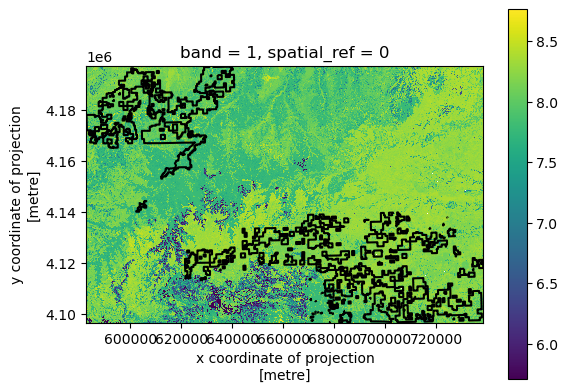

In [12]:
# Quick plot to see pH data of Comanche grassland
comanche_pH_da.plot()
Comanche_gdf.to_crs(utm).boundary.plot(ax= plt.gca(), color= "black")
plt.show()

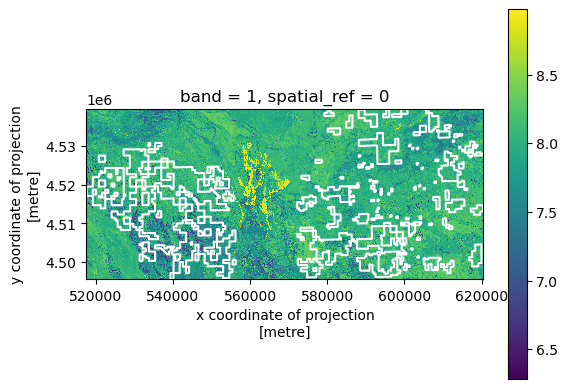

In [13]:
# Quick plot to see pH data of Pawnee grassland
pawnee_pH_da.plot()
Pawnee_gdf.to_crs(utm).boundary.plot(ax= plt.gca(), color= "white")
plt.show()

## Downloading Elevation Data

### Data Citation:
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2024-11-20 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

In [18]:
earthaccess.login()
# Set working directory 
os.makedirs(elevation_dir, exist_ok=True)
srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')

#Setting bounds for my sites 
bounds = tuple(selectedgrass_gdf.total_bounds)

#Creating buffers around the sites 
buffer = .001
xmin, ymin, xmax, ymax = bounds
bounds_buffer= (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
#pxmin, pymin, pxmax, pymax = bounds_pawnee
#bounds_buffer_pawnee = (pxmin-buffer, pymin-buffer, pxmax+buffer, pymax+buffer)

#Downloading elevation data
if not glob(srtm_pattern):
    # Selecting elevation data using site bounds
    srtm_results = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box= bounds_buffer
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

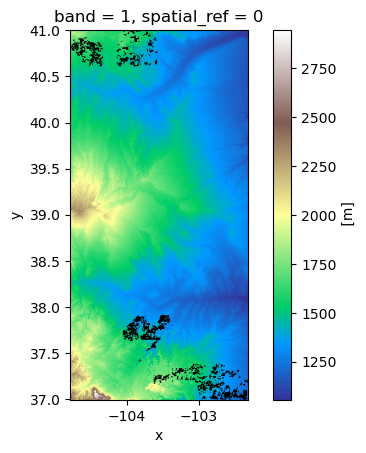

In [19]:
srtm_da_list=[]
for srtm_path in glob(srtm_pattern):
    #Put files into data array
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    #Crop data using site boundaries
    cropped_da = tile_da.rio.clip_box(*bounds_buffer)
    srtm_da_list.append(cropped_da)
    

srtm_da = rxrmerge.merge_arrays(srtm_da_list)
srtm_da.plot(cmap='terrain')
# Plotting my site bounds on top of the elevation data 
selectedgrass_gdf.plot(ax= plt.gca(), color= "black")
plt.show()
#This takes 3 minutes to run and sometimes I run out of memory and need to restart the kernel!
#In the future should run the two grasslands separately

## Calculating Slope 

In [66]:
# Clipping and reprojecting the data so units are in meters into my two sites
# Clip elevation files to bounds with buffers for each site
Comanche_utm_gdf = Comanche_gdf.to_crs(utm)
buffer = .001
bounds_comanche = tuple(Comanche_utm_gdf.total_bounds)
cxmin, cymin, cxmax, cymax = bounds_comanche
bounds_buffer_comanche = (cxmin-buffer, cymin-buffer, cxmax+buffer, cymax+buffer)
comanche_elev_da = (srtm_da
                  .rio.reproject(utm)
                  .rio.clip_box(*bounds_buffer_comanche)
)
#Same but now for Pawnee grassland
Pawnee_utm_gdf = Pawnee_gdf.to_crs(utm)
bounds_pawnee = tuple(Pawnee_utm_gdf.total_bounds)
pxmin, pymin, pxmax, pymax = bounds_pawnee
bounds_buffer_pawnee = (pxmin-buffer, pymin-buffer, pxmax+buffer, pymax+buffer)
pawnee_elev_da = (srtm_da
                  .rio.reproject(utm)
                  .rio.clip_box(*bounds_buffer_pawnee)
)

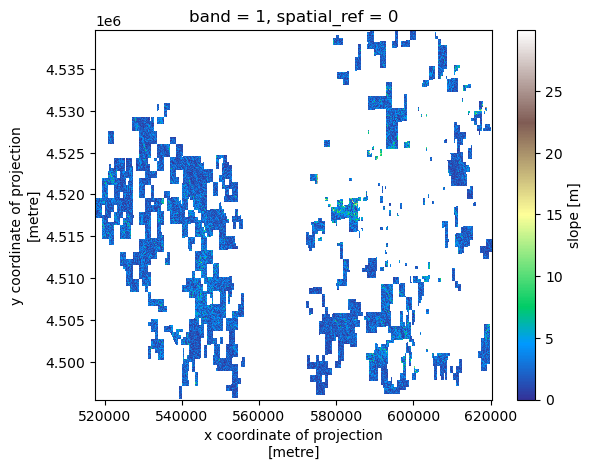

In [67]:
# Checking to see if the clipping worked and plotting slope for Pawnee
pawnee_slope_da = xrspatial.slope(pawnee_elev_da)
pawnee_slope_da_crop = pawnee_slope_da.rio.clip(Pawnee_utm_gdf.geometry)
pawnee_slope_da_crop.plot(cmap='terrain')
#Pawnee_gdf.to_crs(utm).boundary.plot(ax= plt.gca(), color= "white") 
plt.show()

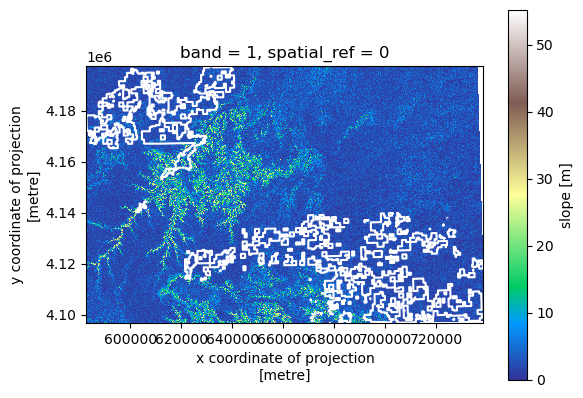

In [28]:
# Plotting Comanche slope
comanche_slope_da = xrspatial.slope(comanche_elev_da)
comanche_slope_da.plot(cmap='terrain')
Comanche_gdf.to_crs(utm).boundary.plot(ax= plt.gca(), color= "white") 
plt.show()

## Downloading Precipitation Data for RCP 8.5 in 50 and 75 years

### Data Citation: 
Northwest Knowledge Network. (2023). MACAv2 Metdata Precipitation Data - CCSM4 [Data set]. Northwest Knowledge Network. Accessed 2024-12-13 from 
http://thredds.northwestknowledge.net:8080/thredds/catalog/MACAV2/BNU-ESM/catalog.html

In [36]:
os.makedirs(precipitation_dir, exist_ok=True)

precip_path = os.path.join(precipitation_dir, '*.nc')
precip_path

'C:\\Users\\anpo9052\\earth-analytics\\data\\final-project\\precipitation\\*.nc'

In [38]:
# Define function to convert longitude/latitude
def convert_longitude(longitude):
    """Convert longitude range from 0-360 t0 -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

# Downloading precipitation data for 8.5 degree projection 
# For 2096-2099 and 2071-2075

maca_da_list = []
for site_name, site_gdf in {
    'Pawnee National Grassland': Pawnee_gdf,
    'Comanche National Grassland': Comanche_gdf}.items():
    for years in ['2096_2099', '2071_2075']:
        # Define url
        maca_url = (
            'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
            '/MACAV2/CCSM4'
            '/macav2metdata_pr_CCSM4_r6i1p1'
            '_rcp85'
            f'_{years}_CONUS'
            '_monthly.nc') 

        # Open & Squeeze dataset
        maca_da = xr.open_dataset(maca_url).squeeze().precipitation

        # Define bounds
        bounds_maca = (site_gdf
                        .to_crs(maca_da.rio.crs)
                        .total_bounds)

        # Change maca_ds longitude values to match the grasslands gdfs
        maca_da = maca_da.assign_coords(
            lon=("lon", [convert_longitude(l) for l in maca_da.lon.values]))

        # Set spatial dimensions of maca_da
        maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

        # Crop maca_da
        maca_da = maca_da.rio.clip_box(*bounds_maca)
        maca_da_list.append(dict(
            site_name=site_name,
            years=years,
            da=maca_da))

maca_df = pd.DataFrame(maca_da_list)
maca_df

,site_name,years,da
0,Pawnee Grasslands,2096_2099,[[[<xarray.DataArray 'precipitation' ()> Size:...
1,Pawnee Grasslands,2071_2075,[[[<xarray.DataArray 'precipitation' ()> Size:...
2,Comache Grasslands,2096_2099,[[[<xarray.DataArray 'precipitation' ()> Size:...
3,Comache Grasslands,2071_2075,[[[<xarray.DataArray 'precipitation' ()> Size:...


In [72]:
def subset_maca_da(df, row, year):
    """
    This function sums MACA climate values across months in each year for a desired data frame row
    and outputs the annual sum for one specified year. 
    
    Parameters
    ----------
    
    df : DataFrame
        The DataFrame the grassland MACA DataArrays are stored in.
    
    row : int
        The row number of the data frame
    
    year: int
        The year for which annual precipitation is extracted
    
    Returns
    -------
    DataArray
        A DataArray of the average total annual precipitation.
    """
    # Subset the data to get one site and one year range
    grassland_years_da = df.loc[row, 'da']

    # Sum the precipitation for all 12 months in each year within the range
    grassland_yearly_precip_da = grassland_years_da.groupby('time.year').sum()

    # Just extract the last year of the dataframe
    grassland_annual_precip_da = grassland_yearly_precip_da.loc[[year]]
    
    # Write the crs and then transform is to utm of 32613
    grass_maca_da = (grassland_annual_precip_da
                            .rio.write_crs(4326)
                            .rio.reproject(utm))
    
    return grass_maca_da

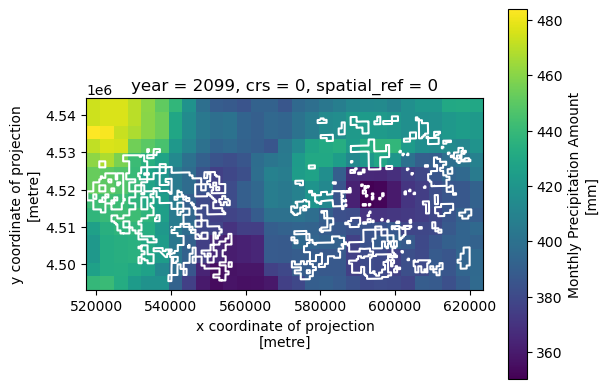

In [73]:
# Getting the annual total precipitaion for Pawnee 2099 and plotting 
Pawnee_precip2099 = subset_maca_da(maca_df, 0, 2099)
Pawnee_precip2099.plot()
Pawnee_utm_gdf.boundary.plot(ax= plt.gca(), color= "white") 
plt.show()

In [74]:
#Extracting annual precipitation for Pawnee and Comanche in 2074 and 2099 
Pawnee_precip2074 = subset_maca_da(maca_df, 1, 2074)
Comanche_precip2074 = subset_maca_da(maca_df, 3, 2074)
Comanche_precip2099 = subset_maca_da(maca_df, 2, 2099)

## Harmonizing the data

In [81]:
# Making sure the grids of each of my data layers match up: 
Pawnee_precip2099_grid = Pawnee_precip2099.rio.reproject_match(pawnee_elev_da)
Pawnee_precip2074_grid = Pawnee_precip2074.rio.reproject_match(pawnee_elev_da)
Comanche_precip2099_grid = Comanche_precip2099.rio.reproject_match(comanche_elev_da)
Comanche_precip2074_grid = Comanche_precip2074.rio.reproject_match(comanche_elev_da)
Pawnee_pH_da_grid = pawnee_pH_da.rio.reproject_match(pawnee_elev_da)
Comanche_pH_da_grid = comanche_pH_da.rio.reproject_match(comanche_elev_da)
Pawnee_slope_da_grid = pawnee_slope_da.rio.reproject_match(pawnee_elev_da)
Comanche_slope_da_grid = comanche_slope_da.rio.reproject_match(comanche_elev_da)

## Fuzzy logic model 

Sorghastrum nutans is currently adapted to the following environmental conditions:

soil pH: 4.8 - 8.0

elevation: up to 6,800 feet (2072 meters)

precipitation: 280-1140 mm per year

slope: less than 25% for most grasses

DESCRIBE FUZZY LOGIC MODEL I GUESS

In [96]:
def suitability(site, year):
    """
    This function uses fuzzy logic to calculate the habitat suitability for Indiangrass
    by multiplying together pixels of elevation, slope, soil pH, and precipitation.  
    
    Parameters
    ----------
    
    site : 
        The grassland site, either "Pawnee" or "Comanche" 

    year: int
        The year for projected annual total precipitation.
    
    Returns
    -------
    DataArray
        A DataArray of habitat suitability for Indiangrass. 
    """
    
    precip = f'{site}_precip{year}_grid' > 400
    elev = f'{site}_elev_da' < 1700
    pH = f'{site}_pH_da_grid' > 4.8
    slope = f'{site}_slope_da_grid' < 20
    suitability_da = pH * slope * elev * precip
    
    
    return suitability_da

## Habitat suitability of Indiangrass in Pawnee National Grassland under 8.5 RCP

### In 50 years (2074)

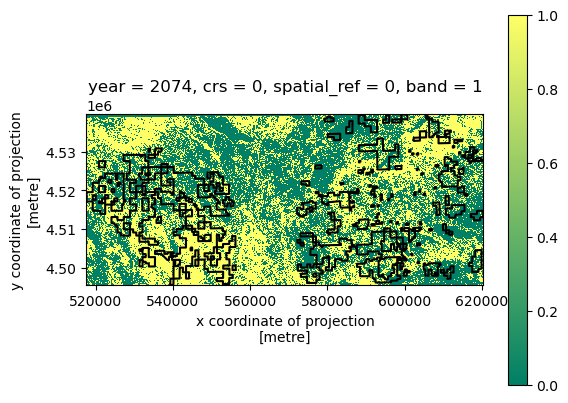

In [125]:
precip_suitable_pawnee_2074 = ((Pawnee_precip2074_grid > 280) * (Pawnee_precip2074_grid < 1140))
elev_suitable_pawnee = pawnee_elev_da < 2072
slope_suitable_pawnee = Pawnee_slope_da_grid < 25
pH_suitable_pawnee = ((Pawnee_pH_da_grid > 4.8) * (Pawnee_pH_da_grid < 8))

pawnee_2074 = precip_suitable_pawnee_2074 * elev_suitable_pawnee * slope_suitable_pawnee * pH_suitable_pawnee
pawnee_2074.plot(cmap='summer')
Pawnee_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.show()

In [140]:
pawnee_2074_da_crop = pawnee_2074.rio.clip(Pawnee_utm_gdf.geometry)
suitable_count2074 = np.count_nonzero(pawnee_2074_da_crop)
print(suitable_count2074)

4866859


### In 75 years (2099)

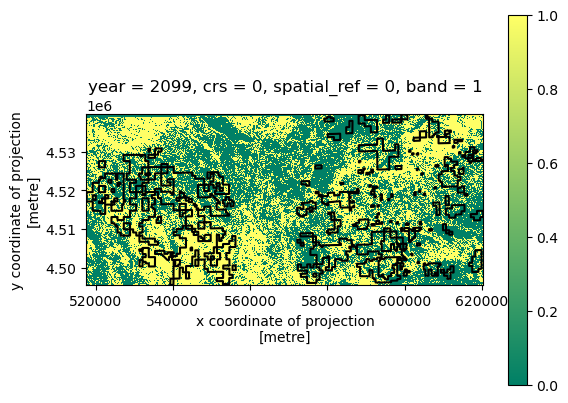

In [128]:
precip_suitable_pawnee_2099 = ((Pawnee_precip2099_grid > 280) * (Pawnee_precip2099_grid < 1140))
elev_suitable_pawnee = pawnee_elev_da < 2072
slope_suitable_pawnee = Pawnee_slope_da_grid < 25
pH_suitable_pawnee = ((Pawnee_pH_da_grid > 4.8) * (Pawnee_pH_da_grid < 8))

pawnee_2099 = precip_suitable_pawnee_2099 * elev_suitable_pawnee * slope_suitable_pawnee * pH_suitable_pawnee
pawnee_2099.plot(cmap="summer")
Pawnee_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.show()

In [141]:
pawnee_2099_da_crop = pawnee_2099.rio.clip(Pawnee_utm_gdf.geometry)
suitable_count2099 = np.count_nonzero(pawnee_2099_da_crop)
print(suitable_count2099)

4866859


## Habitat suitability of Indiangrass in Comanche National Grassland under 8.5 RCP

### In 50 years (2074)

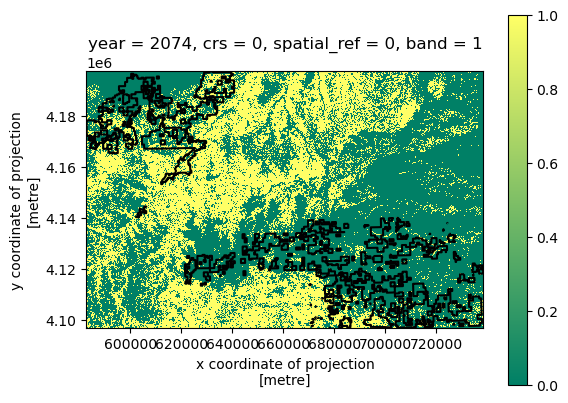

In [137]:
precip_suitable_comanche_2074 = ((Comanche_precip2074_grid > 280) * (Comanche_precip2074_grid < 1140))
elev_suitable_comanche = comanche_elev_da < 2072
slope_suitable_comanche = Comanche_slope_da_grid < 25
pH_suitable_comanche = ((Comanche_pH_da_grid > 4.8) *(Comanche_pH_da_grid < 8))

comanche_2074 = precip_suitable_comanche_2074 * elev_suitable_comanche * slope_suitable_comanche * pH_suitable_comanche
comanche_2074.plot(cmap='summer')
Comanche_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.show()

In [143]:
comanche_2074_da_crop = comanche_2074.rio.clip(Comanche_utm_gdf.geometry)
suitable_comanche2074 = np.count_nonzero(comanche_2074_da_crop)
print(suitable_comanche2074)

16885187


### In 75 years (2099)

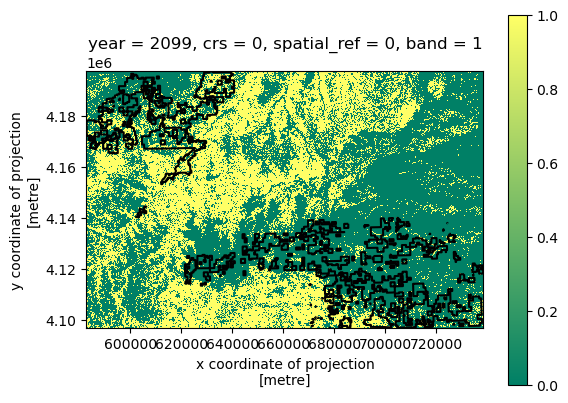

In [138]:
precip_suitable_comanche_2099 = ((Comanche_precip2099_grid > 280) * (Comanche_precip2099_grid < 1140))
elev_suitable_comanche = comanche_elev_da < 2072
slope_suitable_comanche = Comanche_slope_da_grid < 25
pH_suitable_comanche = ((Comanche_pH_da_grid > 4.8) *(Comanche_pH_da_grid < 8))

comanche_2099 = precip_suitable_comanche_2099 * elev_suitable_comanche * slope_suitable_comanche * pH_suitable_comanche
comanche_2099.plot(cmap='summer')
Comanche_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.show()

In [142]:
comanche_2099_da_crop = comanche_2099.rio.clip(Comanche_utm_gdf.geometry)
suitable_comanche2099 = np.count_nonzero(comanche_2099_da_crop)
print(suitable_comanche2099)

16897730
